In [44]:
%matplotlib widget
%matplotlib widget
import os
from pathlib import Path
import time
import torch
import numpy as np
import math
import gc
from functools import partial
from dataset import Dataset, load_dataframes_from_folder, reverse_normalization
from torch.utils.data import DataLoader
from transformer_zerostep import GPTConfig, GPT, warmup_cosine_lr
import argparse
import warnings
import matplotlib.pyplot as plt

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0

In [45]:
# Overall settings
out_dir = "out"
batch_size = 1024

# Compute settings
cuda_device = "cuda:0"
no_cuda = False
threads = 10
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")
print(torch.cuda.is_available())

True


In [46]:
# Create out dir
out_dir = Path(out_dir)
exp_data = torch.load(out_dir/"ckpt_zerostep_sim_matlab_50pct_mix_real_val_noise_h50.pt", map_location=device, weights_only=False)
seq_len = exp_data["cfg"].seq_len
nx = exp_data["cfg"].nx
exp_data["iter_num"]
print(seq_len)
print(exp_data["iter_num"])
print(exp_data['best_val_loss'])
print(exp_data["cfg"])

50
2307
0.007704277784796432
Namespace(model_dir='out', out_file='ckpt_zerostep_sim_matlab_50pct_mix_real_val_noise_h50', in_file='ckpt_zerostep_sim_matlab_50pct_mix_real_val_noise_h50', init_from='resume', seed=42, log_wandb=False, nx=4, nu=4, ny=1, seq_len=50, mag_range=(0.5, 0.97), phase_range=(0.0, 1.5707963267948966), fixed_system=False, n_layer=8, n_head=4, n_embd=16, dropout=0, bias=False, batch_size=64, max_iters=20000, warmup_iters=5000, lr=1e-05, weight_decay=0.0, eval_interval=10, eval_iters=10, fixed_lr=False, threads=16, no_cuda=False, cuda_device='cuda:0', compile=False, beta1=0.9, beta2=0.95, block_size=50, lr_decay_iters=20000, min_lr=1.0000000000000002e-06, decay_lr=True, eval_batch_size=64)


In [47]:
# Expected rmse speed
np.sqrt(exp_data['best_val_loss']) * 2500

219.43503857628957

In [48]:
# # Remove `module.` prefix from keys
# from collections import OrderedDict
# new_state_dict = OrderedDict()
# for k, v in exp_data["model"].items():
#     name = k[7:] if k.startswith("module.") else k  # Remove `module.` prefix
#     new_state_dict[name] = v

In [49]:
exp_data.keys()

dict_keys(['model', 'optimizer', 'model_args', 'iter_num', 'train_time', 'LOSS', 'LOSS_VAL', 'best_val_loss', 'cfg'])

number of parameters: 0.03M


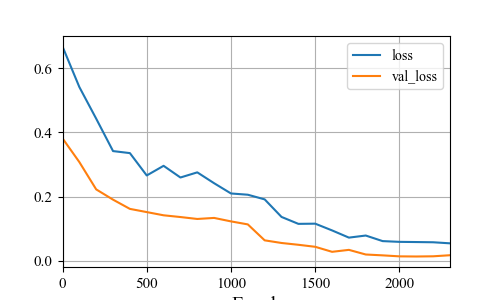

Model size in KB: 100.56640625


In [50]:
model_args = exp_data["model_args"]
gptconf = GPTConfig(**model_args)
model = GPT(gptconf).to(device)


state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    if k.startswith('module.'):
        state_dict[k[7:]] = v
        state_dict.pop(k)

model.load_state_dict(state_dict)

plt.figure(figsize=(5,3))
plt.plot(np.arange(exp_data['iter_num'])[::100], exp_data['LOSS'][::100], label="loss")
plt.plot(np.arange(exp_data['iter_num'])[::100], exp_data['LOSS_VAL'][::100], label="val_loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

size_in_bytes = sum(param.numel() * param.element_size() for param in model.parameters())
size_in_bytes += sum(buffer.numel() * buffer.element_size() for buffer in model.buffers())

# Convert bytes to kilobytes
size_in_kb = size_in_bytes / 1024
print('Model size in KB:', size_in_kb)

In [51]:
# folder_path = '../data/CL_experiments/test/inertia07_ki-0.0061-kp-11.8427'
# folder_path = '../data/CL_experiments/test/inertia04_ki-0.0061-kp-11.8427'
# folder_path = '../../../in-context-bldc-data/simulated/10_percent'
# folder_path = '../../../in-context-bldc-data/simulated/50_percent_longer_steps'
folder_path = '../data/CL_experiments/train/inertia13_ki-0.0061-kp-11.8427'


dfs = load_dataframes_from_folder(folder_path)
# Log the number of DataFrames loaded
print(f"Loaded {len(dfs)} DataFrames from {folder_path}.") 

# Create an instance of the dataset
dataset = Dataset(dfs=dfs, seq_len=1000)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# df_idx = np.random.choice(len(dfs))
# df = dfs[df_idx]
# diff_array = df['r'].diff(-seq_len).to_numpy()
# diff_array = diff_array[~np.isnan(diff_array)]
# prob_ratio = 0.5 # ratio between constant samples and step samples
# if np.random.rand() >= prob_ratio:
#     good_idx = np.flatnonzero(diff_array == 0)
#     if len(good_idx) == 0:
#         good_idx = np.flatnonzero(diff_array != 0)
# else:
#     good_idx = np.flatnonzero(diff_array != 0)
#     if len(good_idx) == 0:
#         good_idx = np.flatnonzero(diff_array == 0)
# start_idx = np.random.choice(good_idx)
# batch_y = torch.tensor(df['omega'].iloc[start_idx:start_idx + seq_len].values, dtype=torch.float32)
# print(batch_y)


# Example of accessing an item
batch_u, batch_y = next(iter(dataloader))
batch_u, batch_y = batch_u.to(device), batch_y.to(device)
batch_y_pred = torch.empty_like(batch_y)
cputime = np.empty(batch_y.shape[1])

b, tt, _ = batch_y.shape 

Loaded 100 DataFrames from ../data/CL_experiments/train/inertia13_ki-0.0061-kp-11.8427.


In [52]:
cputime

array([9.88131292e-324, 9.88131292e-324, 7.90505033e-323, 3.95252517e-323,
       0.00000000e+000,             nan, 1.21165960e-311, 0.00000000e+000,
       0.00000000e+000,             nan, 1.21342126e-311,             nan,
       1.21342126e-311,             nan, 1.21342126e-311, 1.21342126e-311,
       1.21342132e-311, 4.30625279e-096, 1.21342132e-311, 1.21342132e-311,
       1.10430865e+165, 1.21342132e-311, 1.21342132e-311, 1.21342132e-311,
       1.21342132e-311, 1.21342132e-311, 2.42245820e-028, 1.21342132e-311,
       1.04917184e-153, 1.21342132e-311, 1.21342132e-311, 1.69048587e-310,
       5.03436256e+180, 2.37684459e+137, 1.05838939e+214, 8.65020492e-013,
       1.05893701e-153, 6.36828914e+151, 1.16307920e+214, 1.74603185e+238,
       1.31607528e+179, 1.54866788e+132, 4.37303754e+140, 6.19517816e+223,
       1.31607533e+179, 1.54866788e+132, 4.37303754e+140, 6.06009048e+233,
       3.63347084e-143, 1.89130780e+219, 8.82142682e+199, 1.05852296e+214,
       8.82142681e+199, 3

In [53]:
H = exp_data["cfg"].seq_len

with torch.no_grad():
    
    for i in range(tt):
        
        print('time instant:', i)

        # Controller u(t) = C(e(t),u(t-1))
        start = time.time()
        if i < H:
            pred = model(batch_u[:, :i+1, :])
        else:
            pred = model(batch_u[:, i-H+1:i+1, :])
        
        cputime[i] = time.time() - start
        batch_y_pred[:,i,0] = pred[:,-1,0]
        print(cputime[i])

print(np.mean(cputime))
        
# Reverse norm
batch_u, batch_y, batch_y_pred = reverse_normalization(batch_u, batch_y, batch_y_pred)

time instant: 0
0.004012346267700195
time instant: 1
0.002990245819091797
time instant: 2
0.0040051937103271484
time instant: 3
0.00299072265625
time instant: 4
0.0029947757720947266
time instant: 5
0.0030183792114257812
time instant: 6
0.002996206283569336
time instant: 7
0.0030007362365722656
time instant: 8
0.0039861202239990234
time instant: 9
0.0029954910278320312
time instant: 10
0.003007650375366211
time instant: 11
0.0019996166229248047
time instant: 12
0.008484601974487305
time instant: 13
0.00554203987121582
time instant: 14
0.008110523223876953
time instant: 15
0.005846500396728516
time instant: 16
0.0
time instant: 17
0.011701583862304688
time instant: 18
0.0030014514923095703
time instant: 19
0.0030198097229003906
time instant: 20
0.0029802322387695312
time instant: 21
0.003037691116333008
time instant: 22
0.0029840469360351562
time instant: 23
0.003000020980834961
time instant: 24
0.0030052661895751953
time instant: 25
0.002997159957885742
time instant: 26
0.0013456344604

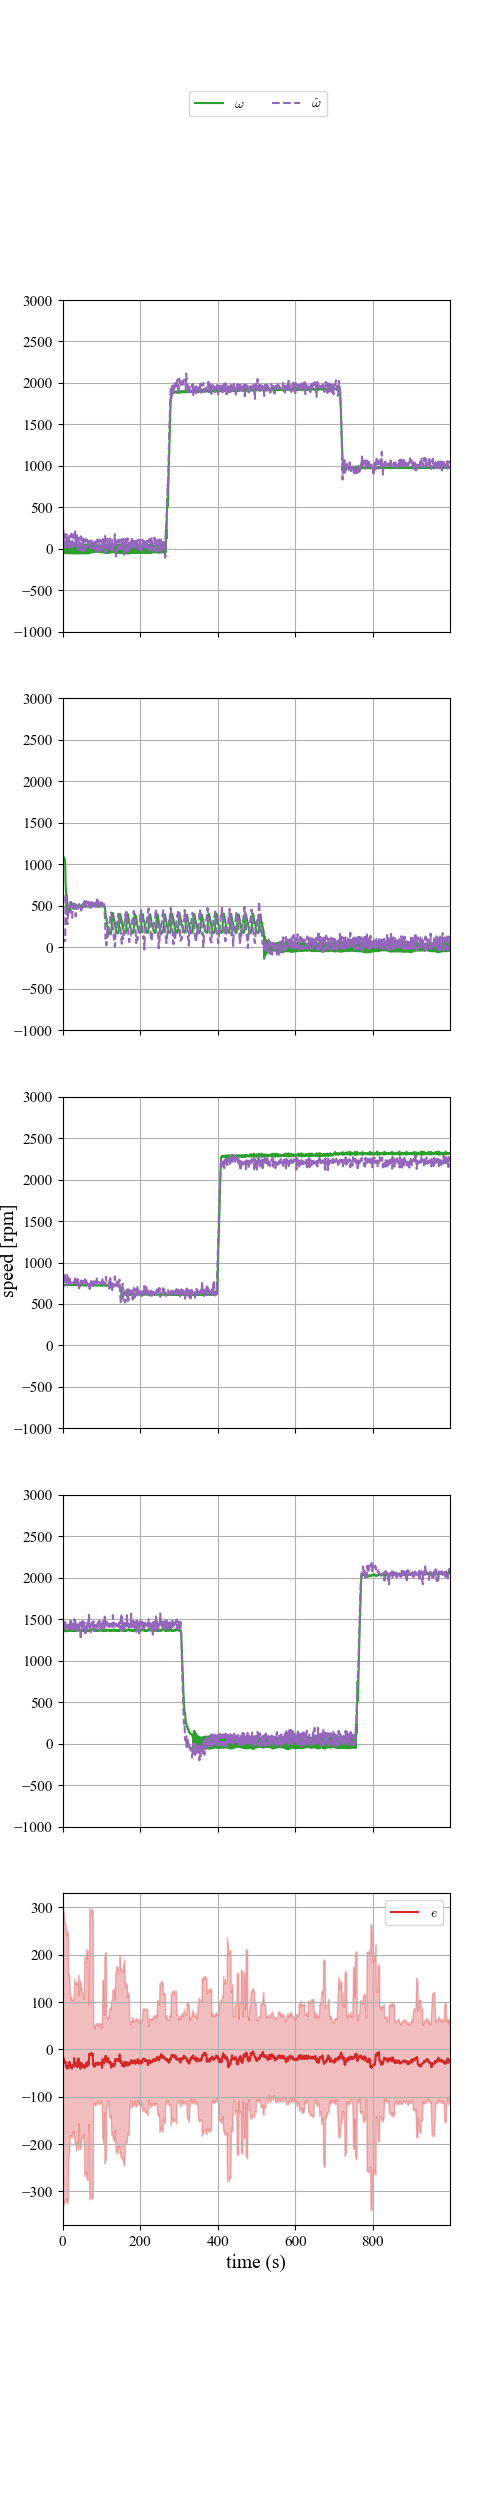

In [54]:
# Convert batch tensors to numpy for plotting
batch_y_np = batch_y.cpu().numpy()  # Shape (seq_len, 1)
batch_y_pred_np = batch_y_pred.cpu().numpy()  # Shape (seq_len, 1)

# Plotting
fig, axes = plt.subplots(5, 1, figsize=(5, 25), sharex=True)

# Plotting in each subplot
for i in range(4):
    axes[i].plot(batch_y_np[i], label=r"$\omega$", color="tab:green")
    axes[i].plot(batch_y_pred_np[i], label=r"$\hat{\omega}$", color="tab:purple", linestyle="--")
    axes[i].set_ylim([-1000, 3000])
axes[0].legend(bbox_to_anchor=(0.7, 1.65), ncols=2)

mean_error = (batch_y_np - batch_y_pred_np).mean(axis=0).flatten()
std_error = (batch_y_np - batch_y_pred_np).std(axis=0).flatten()
mse = ((batch_y_np - batch_y_pred_np)**2).mean()

axes[-1].plot(mean_error, label="$e$", color="tab:red")
axes[-1].fill_between(
    np.arange(mean_error.shape[0]), 
    mean_error + std_error, 
    mean_error - std_error, 
    color='tab:red', 
    alpha=0.3
)
axes[-1].legend()

# Set the x-label for the last subplot
axes[-1].set_xlabel('time (s)')
# Add a common ylabel
fig.text(0.0, 0.5, 'speed [rpm]', va='center', rotation='vertical', fontsize=14)
# plt.savefig('prediction.pdf')
plt.show()

In [55]:
np.sqrt(mean_error**2).mean()

22.256899

In [56]:
np.sqrt((mean_error**2).mean())

23.299576

In [ ]:
print(np.sqrt(mse))

137.76619


: 